<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

***Some parts of the notebook are almost the copy of [ mmta-team course](https://github.com/mmta-team/mmta_fall_2020). Special thanks to mmta-team for making them publicly available. [Original notebook](https://github.com/mmta-team/mmta_fall_2020/blob/master/tasks/01_word_embeddings/task_word_embeddings.ipynb).***

<b> Прочитайте семинар, пожалуйста, для успешного выполнения домашнего задания. В конце ноутка напишите свой вывод. Работа без вывода оценивается ниже.

## Задача поиска схожих по смыслу предложений

Мы будем ранжировать вопросы [StackOverflow](https://stackoverflow.com) на основе семантического векторного представления

До этого в курсе не было речи про задачу ранжировния, поэтому введем математическую формулировку

## Задача ранжирования(Learning to Rank)

* $X$ - множество объектов
* $X^l = \{x_1, x_2, ..., x_l\}$ - обучающая выборка
<br>На обучающей выборке задан порядок между некоторыми элементами, то есть нам известно, что некий объект выборки более релевантный для нас, чем другой:
* $i \prec j$ - порядок пары индексов объектов на выборке $X^l$ c индексами $i$ и $j$
### Задача:
построить ранжирующую функцию $a$ : $X \rightarrow R$ такую, что
$$i \prec j \Rightarrow a(x_i) < a(x_j)$$

<img src="https://d25skit2l41vkl.cloudfront.net/wp-content/uploads/2016/12/Featured-Image.jpg" width=500, height=450>

### Embeddings

Будем использовать предобученные векторные представления слов на постах Stack Overflow.<br>
[A word2vec model trained on Stack Overflow posts](https://github.com/vefstathiou/SO_word2vec)

In [ ]:
!pip install ampligraph

In [ ]:
import zipfile
import os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
os.listdir('/content/drive/My Drive/embeddings/')

Mounted at /content/drive


['stackoverflow_similar_questions.zip', 'SO_vectors_200.bin']

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
wv_embeddings = KeyedVectors.load_word2vec_format("/content/drive/My Drive/embeddings/SO_vectors_200.bin", binary=True)

#### Как пользоваться этими векторами?

Посмотрим на примере одного слова, что из себя представляет embedding

In [ ]:
word = 'dog'
if word in wv_embeddings:
    print(wv_embeddings[word].dtype, wv_embeddings[word].shape)

float32 (200,)


In [ ]:
print(f"Num of words: {len(wv_embeddings.index_to_key)}") # The index2word attribute has been replaced by index_to_key since Gensim 4.0.0.

Num of words: 1787145


Найдем наиболее близкие слова к слову `dog`:

#### Вопрос 1:
* Входит ли слов `cat` топ-5 близких слов к слову `dog`? Какое место?

In [ ]:
# Топ-5 наиболее близких слов к слову "dog" (метод 'most_similar' вычисляет косинусное сходство)
similar_words = wv_embeddings.most_similar("dog", topn=5)

In [ ]:
wv_embeddings["dog"]

array([ 0.6851772 , -1.2778991 , -0.41913974,  1.3623164 , -3.1675398 ,
        0.09950767,  0.6402681 , -1.1245339 , -0.6699619 , -0.6998852 ,
        0.4936771 , -0.40500194, -3.0706816 , -2.2809966 ,  0.85798043,
        2.7093108 ,  0.3492745 , -0.03494101, -0.22330493,  1.2290467 ,
        1.7755157 , -3.158358  , -0.6515983 ,  0.7224096 ,  2.3193083 ,
       -1.7969862 ,  0.40903398, -2.744604  , -1.7179952 , -0.914309  ,
       -0.75887376, -0.35140672, -0.5182776 , -1.9097351 , -0.8300773 ,
        0.02147918,  1.1783471 ,  0.03169126, -0.3069023 ,  1.6666299 ,
        0.6711357 , -2.1706133 , -0.11800487,  0.22336982, -1.2075394 ,
       -0.86297905, -0.63865614,  1.1733794 ,  0.10022762,  0.7017279 ,
        2.7290728 , -0.4640484 , -2.1719306 , -0.3562852 , -1.8449957 ,
        0.10270727,  1.1125596 , -0.8364318 ,  1.9513408 , -0.97937447,
        1.2650859 ,  0.06809282,  0.6477318 , -0.52431005, -0.6103959 ,
       -2.979829  , -0.7889965 , -0.11004248,  1.7603841 , -1.05

In [ ]:
# Выведем 5-ть слов и их значение косинусного сходства со словом "dog"
for word, similarity in similar_words:
    print(word, similarity)

animal 0.8564180135726929
dogs 0.7880866527557373
mammal 0.7623804211616516
cats 0.7621253728866577
animals 0.760793924331665


#### Ответ 1:
  * слово "cat" не входит в топ-5 слов близких к "dog";
  * во множественном числе слово "cats", т.е. "коты или кошки" занимает 4-е место по близости к слову "dog".

### Векторные представления текста

Перейдем от векторных представлений отдельных слов к векторным представлениям вопросов, как к **среднему** векторов всех слов в вопросе. Если для какого-то слова нет предобученного вектора, то его нужно пропустить. Если вопрос не содержит ни одного известного слова, то нужно вернуть нулевой вектор.

In [ ]:
import numpy as np
import re
# you can use your tokenizer
# for example, from nltk.tokenize import WordPunctTokenizer
class MyTokenizer:
    def __init__(self):
        pass
    def tokenize(self, text):
        return re.findall('\w+', text)
tokenizer = MyTokenizer()

In [ ]:
def question_to_vec(question, embeddings, tokenizer, dim=200):
    """
        question: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении

        return: векторное представление для вопроса
    """
    question_vec = []
    for word in tokenizer.tokenize(question.lower()):
        try:
            question_vec.append(embeddings[word])
        except (KeyError):
            continue

    return np.mean(question_vec, axis=0) if len(question_vec) > 0 else np.zeros(dim, dtype='float32')

Теперь у нас есть метод для создания векторного представления любого предложения.

#### Вопрос 2:
* Какая третья(с индексом 2) компонента вектора предложения `I love neural networks` (округлите до 2 знаков после запятой)?

In [ ]:
text = 'I love neural networks'

In [ ]:
tokenizer.tokenize(text.lower())

['i', 'love', 'neural', 'networks']

In [ ]:
# Вывод 3-го элемента вектора предложения `I love neural networks`
tokenizer = MyTokenizer()
round(question_to_vec(text, wv_embeddings, tokenizer)[2],2)

-1.29

In [ ]:
text_tok = question_to_vec(text, wv_embeddings, tokenizer).round(2)

In [ ]:
text_tok # Вывод всего вектора предложения `I love neural networks`

array([-1.01, -1.69, -1.29, -1.37,  0.16,  0.07,  1.12, -0.07,  0.54,
       -0.37,  0.29,  1.03, -2.87, -1.32,  2.21,  1.17,  1.08,  1.85,
       -0.99,  0.87, -0.17,  0.74, -0.78, -0.88, -0.62, -0.16, -0.62,
        0.37,  2.01,  0.26, -1.5 , -1.39, -1.2 , -1.02,  2.76,  1.73,
       -0.19, -0.59, -0.11, -1.89, -1.79, -0.2 , -0.71,  2.49, -0.15,
        1.13,  0.26,  1.32, -0.58, -0.33,  1.68,  0.91, -0.7 ,  2.38,
       -1.76,  3.14,  1.22, -1.06,  0.79,  0.04,  1.16, -0.45, -0.91,
        0.02, -0.86, -1.02, -0.72,  1.07,  0.89, -0.3 ,  1.5 , -0.94,
       -1.68,  1.05,  0.78, -3.34,  0.16,  0.74, -1.4 ,  0.27, -0.74,
        0.38, -1.19, -1.56, -1.62,  0.31, -0.61,  2.3 , -1.54,  1.12,
        1.14, -1.15, -0.59, -0.52,  0.08,  0.56,  0.24,  1.95,  0.53,
        2.65, -0.44, -1.37, -2.31, -1.73,  0.09,  0.53, -1.29,  0.47,
       -0.28,  1.74,  1.24, -0.56,  1.16,  0.42,  1.61,  1.75, -1.78,
        0.44, -1.24,  0.11, -0.6 , -2.02, -0.74,  1.4 , -0.16, -0.68,
       -0.58, -0.4 ,

#### Ответ 2: `-1.29`

### Оценка близости текстов

Представим, что мы используем идеальные векторные представления слов. Тогда косинусное расстояние между дублирующими предложениями должно быть меньше, чем между случайно взятыми предложениями.

Сгенерируем для каждого из $N$ вопросов $R$ случайных отрицательных примеров и примешаем к ним также настоящие дубликаты. Для каждого вопроса будем ранжировать с помощью нашей модели $R + 1$ примеров и смотреть на позицию дубликата. Мы хотим, чтобы дубликат был первым в ранжированном списке.

#### Hits@K
Первой простой метрикой будет количество корректных попаданий для какого-то $K$:
$$ \text{Hits@K} = \frac{1}{N}\sum_{i=1}^N \, [rank\_q_i^{'} \le K],$$
* $\begin{equation*}
[x < 0 ] \equiv
 \begin{cases}
   1, &x < 0\\
   0, &x \geq 0
 \end{cases}
\end{equation*}$ - индикаторная функция
* $q_i$ - $i$-ый вопрос
* $q_i^{'}$ - его дубликат
* $rank\_q_i^{'}$ - позиция дубликата в ранжированном списке ближайших предложений для вопроса $q_i$.

#### DCG@K
Второй метрикой будет упрощенная DCG метрика, учитывающая порядок элементов в списке путем домножения релевантности элемента на вес равный обратному логарифму номера позиции::
$$ \text{DCG@K} = \frac{1}{N} \sum_{i=1}^N\frac{1}{\log_2(1+rank\_q_i^{'})}\cdot[rank\_q_i^{'} \le K],$$
С такой метрикой модель штрафуется за большой ранк корректного ответа

#### Вопрос 3:
* Максимум `Hits@47 - DCG@1`?

<img src='https://hsto.org/files/1c5/edf/dee/1c5edfdeebce4b71a86bdf986d9f88f2.jpg' width=400, height=200>

#### Пример оценок

Вычислим описанные выше метрики для игрушечного примера.
Пусть
* $N = 1$, $R = 3$
* <font color='green'>"Что такое python?"</font> - вопрос $q_1$
* <font color='red'>"Что такое язык python?"</font> - его дубликат $q_i^{'}$

Пусть модель выдала следующий ранжированный список кандидатов:

1. "Как изучить с++?"
2. <font color='red'>"Что такое язык python?"</font>
3. "Хочу учить Java"
4. "Не понимаю Tensorflow"

$\Rightarrow rank\_q_i^{'} = 2$

Вычислим метрику *Hits@K* для *K = 1, 4*:

- [K = 1] $\text{Hits@1} =  [rank\_q_i^{'} \le 1)] = 0$
- [K = 4] $\text{Hits@4} =  [rank\_q_i^{'} \le 4] = 1$

Вычислим метрику *DCG@K* для *K = 1, 4*:
- [K = 1] $\text{DCG@1} = \frac{1}{\log_2(1+2)}\cdot[2 \le 1] = 0$
- [K = 4] $\text{DCG@4} = \frac{1}{\log_2(1+2)}\cdot[2 \le 4] = \frac{1}{\log_2{3}}$

##### Проведем расчеты с применением функций (hits_at_n_score) на примере К = 1, 4

In [ ]:
# пусть N = 1 - количество исходных вопросов 𝑞𝑖
# n (K) - длина рассматриваемого списка любых вариантов ответов перемешанные отрицательные примеры и дубликаты
K1 = 1
K2 = 4
rankings = np.array([2]) # 𝑟𝑎𝑛𝑘_𝑞′ - позиции дубликатов в ранжированном списке ближайших вопросов для вопроса 𝑞𝑖

In [ ]:
import numpy as np
import math
from ampligraph.evaluation.metrics import hits_at_n_score
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# функция для подсчета DCG
def DCG(ranks, Kn):
  return round((sum(math.log2(1 + rank)**(-1) for rank in ranks) / ranks.shape[0]) * hits_at_n_score(ranks, Kn), 2)

In [ ]:
print('Hist@1 = ', hits_at_n_score(rankings, n = K1), ';', 'Hist@4 = ', hits_at_n_score(rankings, n = K2))
print('DCG@1 = ', DCG(ranks = rankings, Kn = K1), ';', 'DCG@4 = ', DCG(ranks = rankings, Kn = K2))

Hist@1 =  0.0 ; Hist@4 =  1.0
DCG@1 =  0.0 ; DCG@4 =  0.63


##### Ответим на вопрос: Максимум Hits@47 - DCG@1?

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# пусть N = 5 - количество исходных вопросов 𝑞𝑖
# n (K) - длина рассматриваемого списка любых вариантов ответов перемешанные отрицательные примеры и дубликаты
K1 = 1
K2 = 47
rankings = np.array([6, 14, 35, 16, 42]) # 𝑟𝑎𝑛𝑘_𝑞′ - позиции дубликатов в ранжированном списке ближайших вопросов для вопроса 𝑞𝑖

In [ ]:
print('Hist@1 = ', hits_at_n_score(rankings, n = K1), ';', 'Hist@47 = ', hits_at_n_score(rankings, n = K2))
print('DCG@1 = ', DCG(ranks = rankings, Kn = K1), ';', 'DCG@47 = ', DCG(ranks = rankings, Kn = K2))

Hist@1 =  0.0 ; Hist@47 =  1.0
DCG@1 =  0.0 ; DCG@47 =  0.25


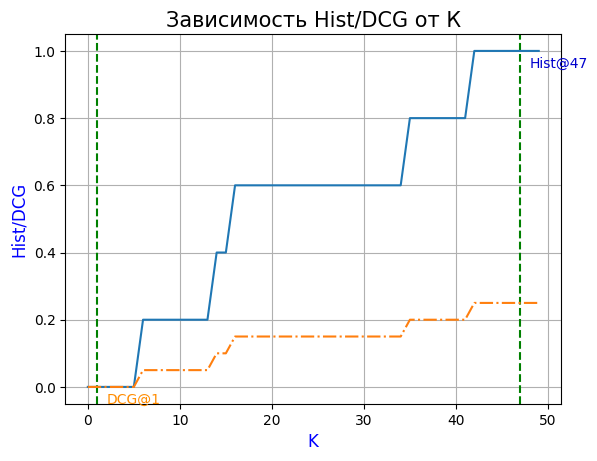

In [ ]:
x = range(50)
y1 = [hits_at_n_score(rankings, n = i) for i in x]
y2 = [DCG(ranks = rankings, Kn = i) for i in x]

plt.title('Зависимость Hist/DCG от К', fontsize=15)
plt.xlabel('K', fontsize=12, color='blue')
plt.ylabel('Hist/DCG', fontsize=12, color='blue')
plt.grid(True)

plt.axvline(x=47, linestyle='--', color='g')
plt.text(48, 0.95, 'Hist@47', color='#0000CD')
plt.axvline(x=1, linestyle='--', color='g')
plt.text(2, -0.05, 'DCG@1', color='#FF8C00')

plt.plot(x, y1, '-', x, y2, '-.');

#### Ответ 3: `Да, максимум.`

#### Вопрос 4:
* Вычислите `DCG@10`, если $rank\_q_i^{'} = 9$(округлите до одного знака после запятой)

In [ ]:
K1 = 10
rankings = np.array([9]) # 𝑟𝑎𝑛𝑘_𝑞′ - позиции дубликатов в ранжированном списке ближайших вопросов для вопроса 𝑞𝑖

In [ ]:
DCG(ranks = rankings, Kn = K1)

0.3

#### Ответ 4: `0.3`

### HITS\_COUNT и DCG\_SCORE

Каждая функция имеет два аргумента: $dup\_ranks$ и $k$. $dup\_ranks$ является списком, который содержит рейтинги дубликатов(их позиции в ранжированном списке). Например, $dup\_ranks = [2]$ для примера, описанного выше.

In [ ]:
def hits_count(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть  Hits@k
    """
    '''your code'''
    hits_value = round(sum([np.zeros(1)[0] if rank > k else np.ones(1)[0] for rank in dup_ranks]) / len(dup_ranks),3)
    return hits_value

In [ ]:
def dcg_score(dup_ranks, k):
    """
        dup_ranks: list индексов дубликатов
        result: вернуть DCG@k
    """
    '''your code'''
    dcg_value = round(sum([np.zeros(1)[0] if rank > k else math.log2(1 + rank)**(-1) for rank in dup_ranks]) / len(dup_ranks),3)
    return dcg_value

Протестируем функции. Пусть $N = 1$, то есть один эксперимент. Будем искать копию вопроса и оценивать метрики.

In [ ]:
import pandas as pd

In [ ]:
copy_answers = ["How does the catch keyword determine the type of exception that was thrown",]

# наши кандидаты
candidates_ranking = [["How Can I Make These Links Rotate in PHP",
                       "How does the catch keyword determine the type of exception that was thrown",
                       "NSLog array description not memory address",
                       "PECL_HTTP not recognised php ubuntu"],]
# dup_ranks — позиции наших копий, так как эксперимент один, то этот массив длины 1
dup_ranks = [2]

# вычисляем метрику для разных k
print('Ваш ответ HIT:', [hits_count(dup_ranks, k) for k in range(1, 5)])
print('Ваш ответ DCG:', [round(dcg_score(dup_ranks, k), 5) for k in range(1, 5)])

Ваш ответ HIT: [0.0, 1.0, 1.0, 1.0]
Ваш ответ DCG: [0.0, 0.631, 0.631, 0.631]


У вас должно получиться

In [ ]:
# correct_answers - метрика для разных k
correct_answers = pd.DataFrame([[0, 1, 1, 1], [0, 1 / (np.log2(3)), 1 / (np.log2(3)), 1 / (np.log2(3))]],
                               index=['HITS', 'DCG'], columns=range(1,5))
correct_answers

,1,2,3,4
HITS,0,1.00000,1.00000,1.00000
DCG,0,0.63093,0.63093,0.63093


### Данные
[arxiv link](https://drive.google.com/file/d/1QqT4D0EoqJTy7v9VrNCYD-m964XZFR7_/edit)

`train.tsv` - выборка для обучения.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>**

`validation.tsv` - тестовая выборка.<br> В каждой строке через табуляцию записаны: **<вопрос>, <похожий вопрос>, <отрицательный пример 1>, <отрицательный пример 2>, ...**

In [ ]:
import zipfile
import os
from google.colab import drive

drive.mount('/content/drive')
os.listdir('/content/drive/My Drive/embeddings/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['stackoverflow_similar_questions.zip', 'SO_vectors_200.bin']

In [ ]:
zipfile.ZipFile('/content/drive/My Drive/embeddings/stackoverflow_similar_questions.zip', 'r').extractall()
display(os.listdir())

['.config', 'application.log', '__MACOSX', 'data', 'drive', 'sample_data']

Считайте данные.

In [ ]:
def read_corpus(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(line.split('\t'))
    return data

Нам понадобиться только файл validation.

In [ ]:
validation_data = read_corpus('./data/validation.tsv')

In [ ]:
pd.DataFrame(validation_data).head(5)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,How to print a binary heap tree without recurs...,How do you best convert a recursive function t...,How can i use ng-model with directive in angul...,flash: drawing and erasing,toggle react component using hide show classname,Use a usercontrol from another project to curr...,~ Paths resolved differently after upgrading t...,Materialize datepicker - Rendering when an ico...,Creating PyPi package - Could not find a versi...,How can I analyze a confusion matrix?,...,JRuby 1.7.0 will not install bundler given ple...,solr multiple tokenizers for query,Is it possible to pass an EJS variable to an A...,How To Read Data using Ip Address,SSIS XML Decryption Message,Detecting selection change on a UITextView?,Different CSS background-image depending on mo...,What's the equivalent averageifs for standard ...,Segmentation faults using f2py,Eclipse: Most useful refactorings\n
1,How to start PhoneStateListener programmatically?,PhoneStateListener and service,Java cast object[] to model,WCF and What does this mean?,How to uncheck checkbox using jQuery Uniform l...,Two projects with same code base,Can't read php file when upload image to serve...,create pandas dataframe from dictionary of dic...,how to pass tkinter text to flex,runtime error project source code not found an...,...,setGraphic() not working correctly on recursiv...,Strange behaviour of sscanf with string,HTTP method for a WCF Restful Service,SubSonic .Filter() in memory filter,Does ASP.NET MVC use the regular toolbox contr...,How can I render a GSP as a String?,publishing ASP.Net MVC 4 Project,how to hyperlink to a TFS item from visual studio,mutex attribute PTHREAD_PROCESS_SHARED inverts...,Unable to call SOAP Webservice using jQuery\n
2,jQuery: Show a div2 when mousenter over div1 i...,when hover on div1 depenting on if it is on di...,How to run selenium in google app engine/cloud?,Python Comparing two lists of strings for simi...,Hazelcast creates 3 nodes/members when configu...,JSON-LD framing single object arrays,Is there a way to print to the console in an A...,Run server-side code on html button press in E...,Sorting an array by alphabetical order before ...,Node - Prevent child process from going in to ...,...,jpa Entity Metadata,How do you use the LaTeX blackboard font in MA...,Python - Importing a global/site-packages modu...,ISCC passing a parameter in the Compiler IDE,"IE8 ignores ""filter"" CSS styles",Is there a way to load a webpage in pieces usi...,"Requiring unknown module ""buffer"" in react-nat...","Eclipse, where to change the current debug lin...",How to wait and get text from another form in ...,HTML document width exceeds 100% when i increa...
3,Performing async method in a loop in node.js a...,Asynchronous sequence of events using promises,Django CMS - not able to upload images through...,Sorting an array by alphabetical order before ...,"SQL, Microsoft SQl",call a function in place in Objective c,jquery .bind() and/or .ready() not working,How to filter a list of required elements in l...,my $self = shift in Perl; an explanation,Error: The digital signature of the Object did...,...,Recursion in C confusion,Finding duplicate values in r,Static variables in Android,Valid XPath expression,Is there a way to make controls transparent to...,"Read csv, then enumerate",How to get weekly data from table?,How to perform an action only after data are d...,Why reduce the size of the Java JVM thread stack?,How can I focus on a Word document I just open...
4,UE4: output game frames to file,Unreal Engine 4: save rendered frame to memory,How to show an default text when an item of th...,simple beginner search program using arrays in...,When typing in editable ComboBox not showing D...,GMap.Net marker initially in incorrect position,What are we doing wrong with git?,LaTeX: remove blank page after a \part or \cha...,What is component level Module in Ionic 2,React to classes added via Jquery,...,How to get

In [ ]:
first_str = pd.DataFrame(validation_data)[0:1]

In [ ]:
pd.DataFrame(first_str[1])

,1
0,How do you best convert a recursive function t...


Кол-во строк

In [ ]:
len(validation_data)

3760

Размер нескольких первых строк

In [ ]:
for i in range(5):
    print(i + 1, len(validation_data[i]))

1 1001
2 1001
3 1001
4 1001
5 1001


### Ранжирование без обучения

Реализуйте функцию ранжирования кандидатов на основе косинусного расстояния. Функция должна по списку кандидатов вернуть отсортированный список пар (позиция в исходном списке кандидатов, кандидат). При этом позиция кандидата в полученном списке является его рейтингом (первый - лучший). Например, если исходный список кандидатов был [a, b, c], и самый похожий на исходный вопрос среди них - c, затем a, и в конце b, то функция должна вернуть список **[(2, c), (0, a), (1, b)]**.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy

In [ ]:
def rank_candidates(question, candidates, embeddings, tokenizer, dim=200):
    """
        question: строка
        candidates: массив строк(кандидатов) [a, b, c]
        result: пары (начальная позиция, кандидат) [(2, c), (0, a), (1, b)]
    """
    '''your code'''
    result = []
    q_vec = question_to_vec(question, embeddings, tokenizer)

    for idx, elem in enumerate(candidates):
        candidate_vec = question_to_vec(elem, embeddings, tokenizer)
        result.append((idx, elem, cosine_similarity(q_vec.reshape(1, -1), candidate_vec.reshape(1, -1))[0][0]))

    result.sort(key=lambda x: x[2], reverse=True)

    return [elem[:-1] for elem in deepcopy(result)]

Протестируйте работу функции на примерах ниже. Пусть $N=2$, то есть два эксперимента

In [ ]:
questions = ['converting string to list', 'Sending array via Ajax fails']

candidates = [['Convert Google results object (pure js) to Python object', # первый эксперимент
               'C# create cookie from string and send it',
               'How to use jQuery AJAX for an outside domain?'],

              ['Getting all list items of an unordered list in PHP',      # второй эксперимент
               'WPF- How to update the changes in list item of a list',
               'select2 not displaying search results']]

In [ ]:
for question, q_candidates in zip(questions, candidates):
        ranks = rank_candidates(question, q_candidates, wv_embeddings, tokenizer)
        print(ranks)
        print()

[(1, 'C# create cookie from string and send it'), (0, 'Convert Google results object (pure js) to Python object'), (2, 'How to use jQuery AJAX for an outside domain?')]

[(0, 'Getting all list items of an unordered list in PHP'), (2, 'select2 not displaying search results'), (1, 'WPF- How to update the changes in list item of a list')]



Для первого экперимента вы можете полностью сравнить ваши ответы и правильные ответы. Но для второго эксперимента два ответа на кандидаты будут <b>скрыты</b>(*)

In [ ]:
# # должно вывести
# results = [[(1, 'C# create cookie from string and send it'),
#             (0, 'Convert Google results object (pure js) to Python object'),
#             (2, 'How to use jQuery AJAX for an outside domain?')],
#            [(*, 'Getting all list items of an unordered list in PHP'), #скрыт
#             (*, 'select2 not displaying search results'), #скрыт
#             (*, 'WPF- How to update the changes in list item of a list')]] #скрыт

Последовательность начальных индексов вы должны получить `для эксперимента 1`  1, 0, 2.

#### Вопрос 5:
* Какую последовательность начальных индексов вы получили `для эксперимента 2`(перечисление без запятой и пробелов, например, `102` для первого эксперимента?

#### Ответ: `021`

Теперь мы можем оценить качество нашего метода. Запустите следующие два блока кода для получения результата. Обратите внимание, что вычисление расстояния между векторами занимает некоторое время (примерно 10 минут). Можете взять для validation 1000 примеров.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, wv_embeddings, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.415 | Hits@   1: 0.415
DCG@   5: 0.502 | Hits@   5: 0.582
DCG@  10: 0.525 | Hits@  10: 0.651
DCG@ 100: 0.570 | Hits@ 100: 0.874
DCG@ 500: 0.583 | Hits@ 500: 0.973
DCG@1000: 0.586 | Hits@1000: 1.000


### Эмбеддинги, обученные на корпусе похожих вопросов

In [ ]:
train_data = read_corpus('./data/train.tsv')

In [ ]:
pd.DataFrame(train_data).head(5)

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,converting string to list,Convert Google results object (pure js) to Pyt...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Which HTML 5 Canvas Javascript to use for maki...,Event handling for geometries in Three.js?\n,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Sending array via Ajax fails,Getting all list items of an unordered list in...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,How to insert CookieCollection to CookieContai...,C# create cookie from string and send it\n,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Updating one element of a bound Observable col...,WPF- How to update the changes in list item of...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
one_str = pd.DataFrame(train_data)[2:3]

In [ ]:
pd.DataFrame(one_str[1])

,1
2,Getting all list items of an unordered list in...


In [ ]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords
stopWords = set(stopwords.words("english"))
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Улучшите качество модели.<br>Склеим вопросы в пары и обучим на них модель Word2Vec из gensim. Выберите размер window. Объясните свой выбор.

In [ ]:
def preproc_nltk(text):
    return ' '.join([word for word in word_tokenize(text.lower()) if word not in stopWords])

In [ ]:
couple_list = [couple[0] + str(' ') + couple[1] for couple in train_data]
words = [preproc_nltk(question).split() for question in couple_list]

In [ ]:
from gensim.models import Word2Vec
embeddings_trained = Word2Vec(words, # данные для обучения модели
                 vector_size=200,    # размерность векторов слов
                 min_count=5,        # игнорирует все слова с общей частотой ниже этой
                 window=5            # максимальное расстояние между текущим и предсказанным словом в предложении
                              ).wv

In [ ]:
wv_ranking = []
max_validation_examples = 1000
for i, line in enumerate(tqdm(validation_data)):
    if i == max_validation_examples:
        break
    q, *ex = line
    ranks = rank_candidates(q, ex, embeddings_trained, tokenizer)
    wv_ranking.append([r[0] for r in ranks].index(0) + 1)

  0%|          | 0/3760 [00:00<?, ?it/s]

In [ ]:
for k in tqdm([1, 5, 10, 100, 500, 1000]):
    print("DCG@%4d: %.3f | Hits@%4d: %.3f" % (k, dcg_score(wv_ranking, k), k, hits_count(wv_ranking, k)))

  0%|          | 0/6 [00:00<?, ?it/s]

DCG@   1: 0.400 | Hits@   1: 0.400
DCG@   5: 0.491 | Hits@   5: 0.571
DCG@  10: 0.517 | Hits@  10: 0.652
DCG@ 100: 0.565 | Hits@ 100: 0.882
DCG@ 500: 0.577 | Hits@ 500: 0.977
DCG@1000: 0.579 | Hits@1000: 1.000


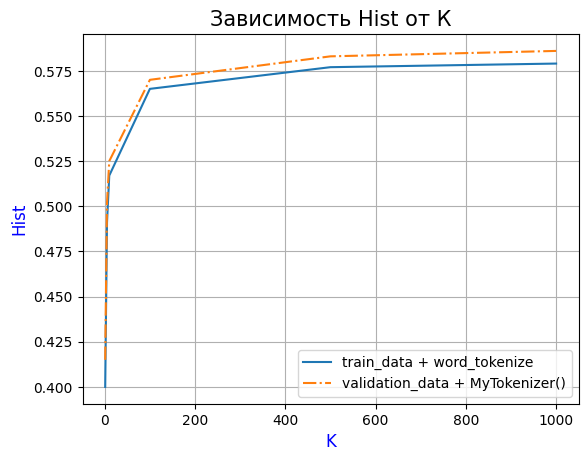

In [ ]:
x = [1, 5, 10, 100, 500, 1000]
w1 = [0.415, 0.502, 0.525, 0.570, 0.583, 0.586]

y1 = [0.400, 0.491, 0.517, 0.565, 0.577, 0.579]

plt.title('Зависимость Hist от К', fontsize=15)
plt.xlabel('K', fontsize=12, color='blue')
plt.ylabel('Hist', fontsize=12, color='blue')
plt.grid(True)

plt.plot(x, y1, '-', label='train_data + word_tokenize')
plt.plot(x, w1, '-.', label='validation_data + MyTokenizer()')
plt.legend(fontsize=10);

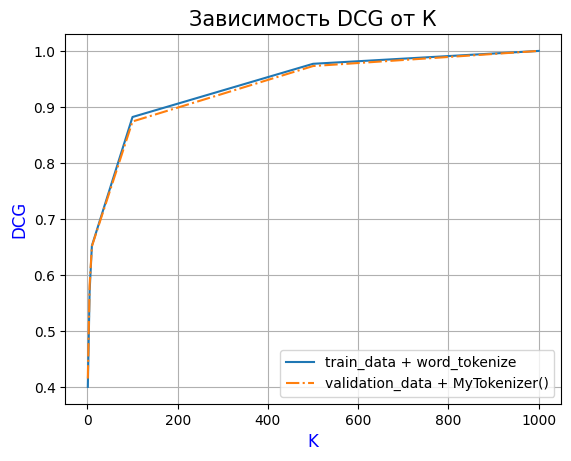

In [ ]:
x = [1, 5, 10, 100, 500, 1000]
w2 = [0.415, 0.582, 0.651, 0.874, 0.973, 1.000]

y2 = [0.400, 0.571, 0.652, 0.882, 0.977, 1.000]

plt.title('Зависимость DCG от К', fontsize=15)
plt.xlabel('K', fontsize=12, color='blue')
plt.ylabel('DCG', fontsize=12, color='blue')
plt.grid(True)

plt.plot(x, y2, '-', label='train_data + word_tokenize')
plt.plot(x, w2, '-.', label='validation_data + MyTokenizer()')
plt.legend(fontsize=10);

### Замечание:
Решить эту задачу с помощью обучения полноценной нейронной сети будет вам предложено, как часть задания в одной из домашних работ по теме "Диалоговые системы".

Напишите свой вывод о полученных результатах.
* Какой принцип токенизации даёт качество лучше и почему?
* Помогает ли нормализация слов?
* Какие эмбеддинги лучше справляются с задачей и почему?
* Почему получилось плохое качество решения задачи?
* Предложите свой подход к решению задачи.

## Вывод:


  1. MyTokenizer() показал лучшее качество по сравнению с word_tokenize, связано это c данными их структурой и т.п.
  2. Нормализация слов не помогла.
  3. Не обученные ембединги справились с задачей  лучше, связано это также с данными их структурой и т.п.
  4.Современные подходы, способные дать лучшее качество, применение Word2Vec носило скорее учебный характер.
  5. На мой взгляд, необходимо  применить нейросетевую модель, например BERT.